In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
np.random.seed(1)
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings("ignore")

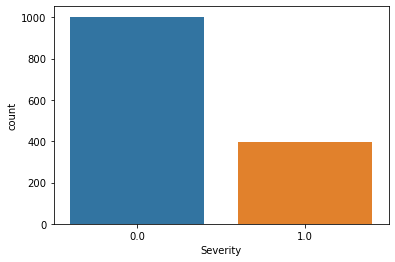

In [2]:
from sklearn.model_selection import train_test_split
train_data = pd.read_csv("covid_variable_nonull.csv",names=['ALC_at_diagnosis','ALC_group_1',
                                                           'PLT_below_20','PLT20','PLT_at_diagnosis',
                                                           'Diabetes','Type_of_ITP','Age_onset',
                                                           'Infection_or_not'])
train_label = pd.read_csv("covid_result_nonull.csv",names=['Severity'])

x_train,x_test,y_train,y_test=train_test_split(train_data,train_label,random_state=1,stratify=train_label)

X_name = ['ALC_at_diagnosis','ALC_group_1','PLT_below_20','PLT20','PLT_at_diagnosis',
        'Diabetes','Type_of_ITP','Age_onset','Infection_or_not']
X_name0 = ["X"+str(i) for i in range(len(X_name))]
Y_name = "Severity"
train_data = pd.concat([x_train,y_train],axis=1)
test_data = pd.concat([x_test,y_test],axis=1)

train_data = np.array(train_data)
train_data = pd.DataFrame(train_data,columns=['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8','Severity'])
test_data = np.array(test_data)
test_data = pd.DataFrame(test_data,columns=['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8','Severity'])

sns.countplot(x = Y_name, data=train_data[[Y_name]])
X_name = X_name0
metrics_order = ["AUC","Accuracy","Sensitivity","Specificity","PPV","NPV","F1"]

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
def evalulate_func(y_true, y_pred, y_pred_proba, model_name="untitled", metrics_lst=["AUC","Accuracy","Sensitivity","Specificity","PPV","NPV","F1"]):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    exec("result_ser = pd.Series(["+",".join(metrics_lst).lower()+"], index="+str(metrics_lst)+",name='"+model_name+"')")
    return locals()['result_ser']

def validate_func(temp_df):
    mean_ser = temp_df.mean().round(3)
    std_ser = temp_df.std().round(3)
    return pd.Series(list(zip(mean_ser,std_ser)),index = temp_df.columns, name = temp_df.index[0])


## !!!!
## NOTE: Train --- 开发队列中用于训练的数据集
## NOTE: Test --- 测试队列中的数据集 (validation)
## NOTE: Validation --- 开发队列中用于验证的数据集 (evaluation)


## use all training data to fit a model, then use the model to predict all the training data and test data
train_df = pd.DataFrame()
test_df = pd.DataFrame()
prob_train_df = pd.DataFrame()
prob_test_df = pd.DataFrame()

## use resampled training data to fit models
stat_train = pd.DataFrame()## statistics on all metrics for various models
resample_train = pd.DataFrame()## accuracy records for each model, for sns.boxplot
prob_train = pd.DataFrame()## probability records for prediction, for roc_curve
stat_test = pd.DataFrame()
resample_test = pd.DataFrame()
prob_test = pd.DataFrame()
stat_val = pd.DataFrame()
resample_val = pd.DataFrame()
prob_val = pd.DataFrame()
model_name_lst = []

In [4]:
training_lst = []
validation_lst = []
lst = range(len(train_data))
resample_num = 10###
resample_y_train = []
resample_y_test = []
resample_y_val = []
kf = KFold(resample_num, random_state = 1, shuffle = True)
for train_idx, test_idx in kf.split(train_data):
    X_train, y_train = train_data.loc[train_idx, X_name], train_data.loc[train_idx, Y_name]
    X_val, y_val = train_data.loc[test_idx, X_name], train_data.loc[test_idx, Y_name]
    validation_lst.append(test_idx)
    training_lst.append(train_idx)
    resample_y_train.extend(y_train.values.tolist())
    resample_y_test.extend(test_data[Y_name].values.tolist())    
    resample_y_val.extend(y_val.values.tolist())

### kNN

No of neighbours: 1


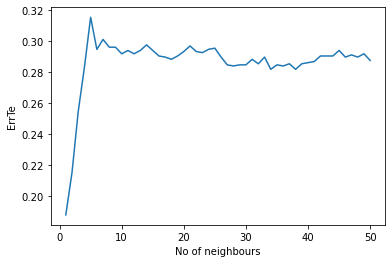

In [5]:
from sklearn.neighbors import KNeighborsClassifier
####################### Grid Search Cross Validation ######################
n_folds = 10
kf = KFold(n_folds, random_state = 1, shuffle = True)
kf.get_n_splits(train_data)
Kmax = 50
ErrCV = np.zeros((Kmax, n_folds))
f = 0
for train_idx, test_idx in kf.split(train_data):
    X_train, y_train = train_data.loc[train_idx, X_name], train_data.loc[train_idx, Y_name]
    X_test, y_test = train_data.loc[test_idx, X_name], train_data.loc[test_idx, Y_name]
    for kk in range(1, Kmax+1):
        kNN = KNeighborsClassifier(n_neighbors=kk)
        kNN.fit(X_train, y_train)
        y_pred = kNN.predict(X_test)
        ErrCV[kk-1, f] = (y_pred != y_test).mean()
    f += 1

# Plot average CV error
sns.lineplot(x = np.arange(1, Kmax+1), y = ErrCV.mean(axis = 1))
plt.xlabel("No of neighbours")
plt.ylabel("ErrTe")
optimal_kk = np.argmin(ErrCV.mean(axis = 1))+1
print("No of neighbours:", optimal_kk)

model_name = "kNN"
model_name_lst.append(model_name)
####################### Fitting ######################
kNN = KNeighborsClassifier(n_neighbors=optimal_kk)
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
kNN.fit(X_train, y_train)
y_pred = kNN.predict(X_train)
y_pred_prob = kNN.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred, y_pred_prob, model_name))
y_pred = kNN.predict(X_test)
y_pred_prob = kNN.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred, y_pred_prob, model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    kNN.fit(X_train, y_train)
    y_pred1 = kNN.predict(X_train)
    y_pred_prob1 = kNN.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = kNN.predict(X_test)
    y_pred_prob2 = kNN.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = kNN.predict(X_val)
    y_pred_prob3 = kNN.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_val[model_name] = temp_prob_val

### Naive Bayes

In [6]:
from sklearn.naive_bayes import BernoulliNB
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_nb = make_pipeline(BernoulliNB())
param_grid = {'bernoullinb__alpha': [0.001,0.01,0.1]}
gs_nb = GridSearchCV(estimator=pipe_nb,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_nb.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_nb.best_estimator_))


model_name = "Naive Bayes"
model_name_lst.append(model_name)
####################### Fitting ######################
nb = BernoulliNB(alpha = gs_nb.best_params_['bernoullinb__alpha'])
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
nb.fit(X_train, y_train)
y_pred = nb.predict(X_train)
y_pred_prob = nb.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = nb.predict(X_test)
y_pred_prob = nb.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    nb.fit(X_train, y_train)
    y_pred1 = nb.predict(X_train)
    y_pred_prob1 = nb.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = nb.predict(X_test)
    y_pred_prob2 = nb.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = nb.predict(X_val)
    y_pred_prob3 = nb.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())## Accuracy --> Sensitivity
prob_val[model_name] = temp_prob_val

Best Estimator: 
Pipeline(steps=[('bernoullinb', BernoulliNB(alpha=0.001))])



### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression


pipe_logi = make_pipeline(LogisticRegression())
param_grid = {'logisticregression__random_state':[None,1],'logisticregression__tol':[0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001],'logisticregression__C': [0.5,1.0,2.0,2.5,3.0]}
gs_logi = GridSearchCV(estimator=pipe_logi,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_logi.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_logi.best_estimator_))

model_name = "Logistic"
model_name_lst.append(model_name)
####################### Fitting #####################
logi = LogisticRegression(random_state=gs_logi.best_params_['logisticregression__random_state'],tol=gs_logi.best_params_['logisticregression__tol'],C=gs_logi.best_params_['logisticregression__C'])
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
logi.fit(X_train, y_train)
y_pred = logi.predict(X_train)
y_pred_prob = logi.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = logi.predict(X_test)
y_pred_prob = logi.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    logi.fit(X_train, y_train)
    y_pred1 = logi.predict(X_train)
    y_pred_prob1 = logi.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = logi.predict(X_test)
    y_pred_prob2 = logi.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = logi.predict(X_val)
    y_pred_prob3 = logi.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

Best Estimator: 
Pipeline(steps=[('logisticregression', LogisticRegression(C=2.0, tol=1e-10))])



### LDA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_lda = make_pipeline(LinearDiscriminantAnalysis())
param_grid = {'lineardiscriminantanalysis__solver': ['lsqr', 'eigen'], 'lineardiscriminantanalysis__shrinkage': [0.001,0.01,0.1,1],'lineardiscriminantanalysis__tol':[0.00000001,0.0000001,0.000001,0.00001,0.0001]}
gs_lda = GridSearchCV(estimator=pipe_lda,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_lda.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_lda.best_estimator_))
# pipe_lda = make_pipeline(LinearDiscriminantAnalysis())
# param_grid = {'lineardiscriminantanalysis__solver': ['lsqr', 'eigen'], 'lineardiscriminantanalysis__shrinkage': [0.001,0.01,0.1,1]}
# gs_lda = GridSearchCV(estimator=pipe_lda,param_grid=param_grid, scoring="accuracy", cv = 5)
# gs_lda.fit(X_train, y_train)
# print("Best Estimator: \n{}\n".format(gs_lda.best_estimator_))


model_name = "LDA"
model_name_lst.append(model_name)
####################### Fitting ######################
# lda = LinearDiscriminantAnalysis(solver = gs_lda.best_params_['lineardiscriminantanalysis__solver'], shrinkage = gs_lda.best_params_['lineardiscriminantanalysis__shrinkage'])
# X_train = train_data[X_name]
lda = LinearDiscriminantAnalysis(solver = gs_lda.best_params_['lineardiscriminantanalysis__solver'], shrinkage = gs_lda.best_params_['lineardiscriminantanalysis__shrinkage'],tol=gs_lda.best_params_['lineardiscriminantanalysis__tol'])
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
lda.fit(X_train, y_train)
y_pred = lda.predict(X_train)
y_pred_prob = lda.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = lda.predict(X_test)
y_pred_prob = lda.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    lda.fit(X_train, y_train)
    y_pred1 = lda.predict(X_train)
    y_pred_prob1 = lda.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = lda.predict(X_test)
    y_pred_prob2 = lda.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = lda.predict(X_val)
    y_pred_prob3 = lda.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

Best Estimator: 
Pipeline(steps=[('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(shrinkage=0.001, solver='lsqr',
                                            tol=1e-08))])



### Decision Tree

optimal terminal nodes: 20


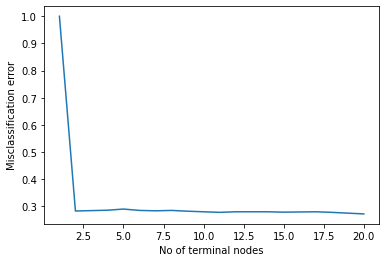

In [9]:
from sklearn.tree import DecisionTreeClassifier
n_folds = 10
kf = KFold(n_folds, random_state = 1, shuffle = True)
kf.get_n_splits(train_data)
nodes_max = 20
ErrCV = np.zeros((nodes_max, n_folds))
f = 0
for train_idx, test_idx in kf.split(train_data):
    X_train, y_train = train_data.loc[train_idx,X_name], train_data.loc[train_idx, Y_name]
    X_test, y_test = train_data.loc[test_idx,X_name], train_data.loc[test_idx, Y_name]

    for node in range(1,nodes_max+1):
        try:
            tree_class = DecisionTreeClassifier(random_state = node-1, max_leaf_nodes = node)
            tree_class.fit(X_train, y_train)
            y_pred = tree_class.predict(X_test)
            ErrCV[node-1, f] = (y_pred != y_test).mean()
        except:
            ErrCV[node-1, f] = 1
    f += 1
ErrCV = ErrCV.mean(axis = 1)

# Plot average CV error
sns.lineplot(x = np.arange(1,nodes_max+1), y = ErrCV)
plt.xlabel("No of terminal nodes")
plt.ylabel("Misclassification error")
cv_max_nodes = np.argmin(ErrCV)+1
# # cv_max_nodes = sorted(list(zip(ErrCV, range(nodes_max))),key=lambda t:(t[0],-t[1]))[0][1]+1
print("optimal terminal nodes:",cv_max_nodes)

model_name = "Decision Tree"
model_name_lst.append(model_name)
####################### Fitting ######################
ctree = DecisionTreeClassifier(random_state = cv_max_nodes-1, max_leaf_nodes = cv_max_nodes)
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
ctree.fit(X_train, y_train)
y_pred = ctree.predict(X_train)
y_pred_prob = ctree.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = ctree.predict(X_test)
y_pred_prob = ctree.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    ctree.fit(X_train, y_train)
    y_pred1 = ctree.predict(X_train)
    y_pred_prob1 = ctree.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = ctree.predict(X_test)
    y_pred_prob2 = ctree.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = ctree.predict(X_val)
    y_pred_prob3 = ctree.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val


### Random Forest

Best Estimator: 
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_features='sqrt', n_estimators=80,
                                        oob_score=True, random_state=1))])



Text(0.5, 0, 'Gini importance')

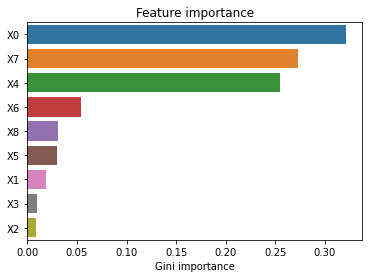

In [10]:
from sklearn.ensemble import RandomForestClassifier
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_rf = make_pipeline(RandomForestClassifier(max_features = "sqrt", oob_score = True, random_state=1))
param_grid = {'randomforestclassifier__n_estimators': [10,20,30,40,50,60,70,80,90,100,110]}
gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=param_grid, scoring="roc_auc", cv = 10)
gs_rf.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_rf.best_estimator_))

model_name = "Random Forest"
model_name_lst.append(model_name)
####################### Fitting ######################
# rf = RandomForestClassifier(max_features = "sqrt", n_estimators = gs_rf.best_params_['randomforestclassifier__n_estimators'], max_depth = gs_rf.best_params_['randomforestclassifier__max_depth'], random_state = 1, oob_score = True)
# X_train = train_data[X_name]
rf = RandomForestClassifier(max_features = "sqrt", n_estimators = gs_rf.best_params_['randomforestclassifier__n_estimators'], 
                            random_state=1,oob_score = True)
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_prob = rf.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    rf.fit(X_train, y_train)
    y_pred1 = rf.predict(X_train)
    y_pred_prob1 = rf.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = rf.predict(X_test)
    y_pred_prob2 = rf.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = rf.predict(X_val)
    y_pred_prob3 = rf.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

# plot feature importance
features = X_train.columns
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")


### Gradient Boosting

Best Estimator: 
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                            n_estimators=500,
                                            random_state=1))])



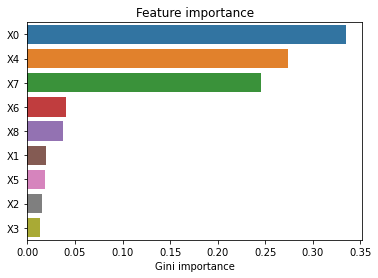

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_gbm = make_pipeline(GradientBoostingClassifier(max_features = "sqrt"))
param_grid = {'gradientboostingclassifier__max_depth': [1,2,3,4,5], 'gradientboostingclassifier__learning_rate': [0.001,0.01,0.1],'gradientboostingclassifier__n_estimators': [50,100,200,500],'gradientboostingclassifier__random_state':[None,1]}
gs_gbm = GridSearchCV(estimator=pipe_gbm,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_gbm.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_gbm.best_estimator_))

model_name = "GBM"
model_name_lst.append(model_name)
####################### Fitting ######################
# gbm = GradientBoostingClassifier(n_estimators = 500, max_depth = gs_gbm.best_params_['gradientboostingclassifier__max_depth'], learning_rate = gs_gbm.best_params_['gradientboostingclassifier__learning_rate'], random_state = 1, max_features = "sqrt")
# X_train = train_data[X_name]
gbm = GradientBoostingClassifier(n_estimators = gs_gbm.best_params_['gradientboostingclassifier__n_estimators'], max_depth = gs_gbm.best_params_['gradientboostingclassifier__max_depth'], learning_rate = gs_gbm.best_params_['gradientboostingclassifier__learning_rate'], random_state = gs_gbm.best_params_['gradientboostingclassifier__random_state'], max_features = "sqrt")
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_train)
y_pred_prob = gbm.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = gbm.predict(X_test)
y_pred_prob = gbm.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    gbm.fit(X_train, y_train)
    y_pred1 = gbm.predict(X_train)
    y_pred_prob1 = gbm.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = gbm.predict(X_test)
    y_pred_prob2 = gbm.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = gbm.predict(X_val)
    y_pred_prob3 = gbm.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

# plot feature importance
features = X_train.columns
importances = gbm.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")
plt.show()

### Adaptive Boosting

Best Estimator: 
Pipeline(steps=[('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=1, n_estimators=4))])



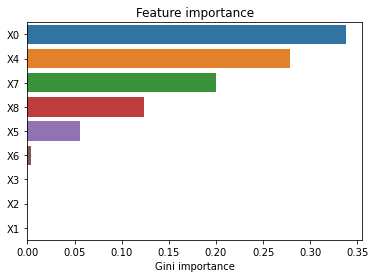

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
base_estimator = DecisionTreeClassifier(max_depth=3)
pipe_ada = make_pipeline(AdaBoostClassifier(base_estimator, algorithm='SAMME.R'))
param_grid = {'adaboostclassifier__learning_rate':[0.001,0.01,0.1,1],'adaboostclassifier__n_estimators':[1,2,3,4,5,6,7,8,9,10]}
gs_ada = GridSearchCV(estimator=pipe_ada,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_ada.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_ada.best_estimator_))

model_name = "AdaBoost"
model_name_lst.append(model_name)
####################### Fitting ######################
# ada = AdaBoostClassifier(base_estimator, n_estimators = 500, learning_rate = gs_ada.best_params_['adaboostclassifier__learning_rate'], random_state = 1)
# X_train = train_data[X_name]
ada = AdaBoostClassifier(base_estimator,learning_rate = gs_ada.best_params_['adaboostclassifier__learning_rate'],
                         n_estimators = gs_ada.best_params_['adaboostclassifier__n_estimators'])
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
ada.fit(X_train, y_train)
y_pred = ada.predict(X_train)
y_pred_prob = ada.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = ada.predict(X_test)
y_pred_prob = ada.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    ada.fit(X_train, y_train)
    y_pred1 = ada.predict(X_train)
    y_pred_prob1 = ada.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = ada.predict(X_test)
    y_pred_prob2 = ada.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = ada.predict(X_val)
    y_pred_prob3 = ada.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

# plot feature importance
features = X_train.columns
importances = ada.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")
plt.show()

### Extreme Gradient Boosting (XGBoost)

Best Estimator: 
Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])



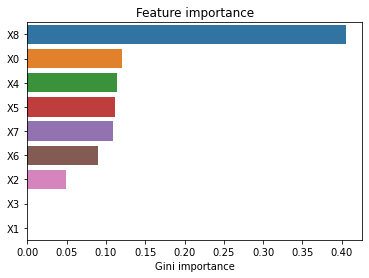

In [13]:
from xgboost import XGBClassifier
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_xgb = make_pipeline(XGBClassifier(random_state = None,eval_metric='logloss',objective='binary:logistic'))
param_grid = {'xgbclassifier__max_depth':[1,2,3,4,5,6,7,8],'xgbclassifier__learning_rate': [0.001,0.01,0.1],'xgbclassifier__n_estimators':[5,6,7,8,9,10,15,20,50],'xgbclassifier__scale_pos_weight':[1,2]}
gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_xgb.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_xgb.best_estimator_))

model_name = "XGBoost"
model_name_lst.append(model_name)
####################### Fitting ######################
xgb = XGBClassifier(max_depth = gs_xgb.best_params_['xgbclassifier__max_depth'],random_state = 1, n_estimators=gs_xgb.best_params_['xgbclassifier__n_estimators'], 
                    learning_rate = gs_xgb.best_params_['xgbclassifier__learning_rate'],scale_pos_weight= gs_xgb.best_params_['xgbclassifier__scale_pos_weight'],eval_metric='logloss')
# xgb = XGBClassifier(max_depth = 1, random_state = 1, n_estimators=500, learning_rate = gs_xgb.best_params_['xgbclassifier__learning_rate'], eval_metric='logloss')
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
y_pred_prob = xgb.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    xgb.fit(X_train, y_train)
    y_pred1 = xgb.predict(X_train)
    y_pred_prob1 = xgb.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = xgb.predict(X_test)
    y_pred_prob2 = xgb.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = xgb.predict(X_val)
    y_pred_prob3 = xgb.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val

# plot feature importance
features = X_train.columns
importances = xgb.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")
plt.show()


### LightGBM

Best Estimator: 
Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(learning_rate=1, max_depth=-10, n_estimators=24,
                                random_state=1))])



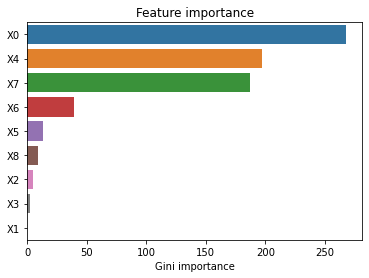

In [14]:
from lightgbm import LGBMClassifier
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_lgbm = make_pipeline(LGBMClassifier(random_state = 1))
param_grid = {'lgbmclassifier__learning_rate': [0.001,0.01,0.1,1],'lgbmclassifier__max_depth':[-10,-9,-8],
             'lgbmclassifier__n_estimators':[18,19,20,21,22,23,24,25]}
gs_lgbm = GridSearchCV(estimator=pipe_lgbm,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_lgbm.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_lgbm.best_estimator_))


model_name = "LGBM"
model_name_lst.append(model_name)
####################### Fitting ######################
# lgbm = LGBMClassifier(max_depth = 1, random_state = 1, n_estimators=500, learning_rate = gs_lgbm.best_params_['lgbmclassifier__learning_rate'])
# X_train = train_data[X_name]
lgbm = LGBMClassifier(max_depth = gs_lgbm.best_params_['lgbmclassifier__max_depth'], random_state = 1, 
                      n_estimators=gs_lgbm.best_params_['lgbmclassifier__n_estimators'], learning_rate = gs_lgbm.best_params_['lgbmclassifier__learning_rate'])
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_train)
y_pred_prob = lgbm.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = lgbm.predict(X_test)
y_pred_prob = lgbm.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    lgbm.fit(X_train, y_train)
    y_pred1 = lgbm.predict(X_train)
    y_pred_prob1 = lgbm.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = lgbm.predict(X_test)
    y_pred_prob2 = lgbm.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = lgbm.predict(X_val)
    y_pred_prob3 = lgbm.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val
# plot feature importance
features = X_train.columns
importances = lgbm.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x = importances[idx], y = features[idx])
plt.title("Feature importance")
plt.xlabel("Gini importance")
plt.show()


### SVM

In [15]:
from sklearn.svm import SVC
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
pipe_svm = make_pipeline(SVC(random_state = 1, max_iter=100000, probability = True))
param_grid = {'svc__C': [0.01,0.1,1], 'svc__kernel': ['linear', 'poly', 'rbf'],
              'svc__gamma': [0.001,0.01,0.1]}
gs_svm = GridSearchCV(estimator=pipe_svm,param_grid=param_grid, scoring="accuracy", cv = 10)
gs_svm.fit(X_train, y_train)
print("Best Estimator: \n{}\n".format(gs_svm.best_estimator_))


model_name = "SVM"
model_name_lst.append(model_name)
####################### Fitting ######################

svm = SVC(random_state = 1, max_iter=100000, probability = True, C = gs_svm.best_params_['svc__C'], kernel  = gs_svm.best_params_['svc__kernel'], gamma = gs_svm.best_params_['svc__gamma'])
X_train = train_data[X_name]
y_train = train_data[Y_name]
X_test = test_data[X_name]
y_test = test_data[Y_name]
svm.fit(X_train, y_train)
y_pred = svm.predict(X_train)
y_pred_prob = svm.predict_proba(X_train)[:,1]## change model_name
prob_train_df[model_name] = y_pred_prob## add
train_df = train_df.append(evalulate_func(y_train, y_pred,y_pred_prob,model_name))
y_pred = svm.predict(X_test)
y_pred_prob = svm.predict_proba(X_test)[:,1]## change model_name
prob_test_df[model_name] = y_pred_prob## add
test_df = test_df.append(evalulate_func(y_test, y_pred,y_pred_prob,model_name))

####################### Resampling ######################
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()
temp_val = pd.DataFrame()
temp_prob_train = []
temp_prob_test = []
temp_prob_val = []
for i in range(resample_num):
    X_train = train_data.loc[training_lst[i],X_name]
    y_train = train_data.loc[training_lst[i],Y_name]
    X_val = train_data.loc[validation_lst[i],X_name]
    y_val = train_data.loc[validation_lst[i],Y_name]
    svm.fit(X_train, y_train)
    y_pred1 = svm.predict(X_train)
    y_pred_prob1 = svm.predict_proba(X_train)[:,1]
    temp_train = temp_train.append(evalulate_func(y_train,y_pred1,y_pred_prob1,model_name))
    temp_prob_train.extend(y_pred_prob1)
    y_pred2 = svm.predict(X_test)
    y_pred_prob2 = svm.predict_proba(X_test)[:,1]
    temp_test = temp_test.append(evalulate_func(y_test,y_pred2,y_pred_prob2,model_name))
    temp_prob_test.extend(y_pred_prob2)
    y_pred3 = svm.predict(X_val)
    y_pred_prob3 = svm.predict_proba(X_val)[:,1]
    temp_val = temp_val.append(evalulate_func(y_val,y_pred3,y_pred_prob3,model_name))
    temp_prob_val.extend(y_pred_prob3)
stat_train = stat_train.append(validate_func(temp_train))
resample_train = resample_train.append(temp_train.Sensitivity.reset_index())
prob_train[model_name] = temp_prob_train
stat_test = stat_test.append(validate_func(temp_test))
resample_test = resample_test.append(temp_test.Sensitivity.reset_index())
prob_test[model_name] = temp_prob_test
stat_val = stat_val.append(validate_func(temp_val))
resample_val = resample_val.append(temp_val.Sensitivity.reset_index())
prob_val[model_name] = temp_prob_val


Best Estimator: 
Pipeline(steps=[('svc',
                 SVC(C=1, gamma=0.1, max_iter=100000, probability=True,
                     random_state=1))])



### Evaluation & Validation

In [16]:
train_df[metrics_order]

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
kNN,0.998734,0.999285,0.997468,1.000000,1.000000,0.999004,0.998733
Naive Bayes,0.631822,0.720315,0.156962,0.942173,0.516667,0.739437,0.240777
Logistic,0.640400,0.719599,0.121519,0.955135,0.516129,0.734100,0.196721
LDA,0.633855,0.717454,0.040506,0.984048,0.500000,0.722548,0.074941
Decision Tree,0.760575,0.771102,0.397468,0.918245,0.656904,0.794651,0.495268
Random Forest,0.999997,0.999285,0.997468,1.000000,1.000000,0.999004,0.998733
GBM,0.999624,0.992132,0.977215,0.998006,0.994845,0.991089,0.985951
AdaBoost,0.771648,0.762518,0.270886,0.956132,0.708609,0.769046,0.391941
XGBoost,0.995818,0.977110,0.959494,0.984048,0.959494,0.984048,0.959494
LGBM,0.999997,0.999285,0.997468,1.000000,1.000000,0.999004,0.998733


In [17]:
train_df[metrics_order].to_csv("file_name.csv")
train_df[metrics_order].to_excel("file_name.xlsx")

In [18]:
test_df[metrics_order]

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
kNN,0.755217,0.813305,0.621212,0.889222,0.689076,0.855908,0.653386
Naive Bayes,0.677021,0.751073,0.189394,0.973054,0.735294,0.752315,0.301205
Logistic,0.689553,0.744635,0.151515,0.979042,0.740741,0.744875,0.251572
LDA,0.673585,0.736052,0.068182,1.000000,1.000000,0.730853,0.127660
Decision Tree,0.728339,0.781116,0.371212,0.943114,0.720588,0.791457,0.490000
Random Forest,0.890855,0.826180,0.553030,0.934132,0.768421,0.840970,0.643172
GBM,0.851025,0.817597,0.606061,0.901198,0.707965,0.852691,0.653061
AdaBoost,0.689904,0.727468,0.174242,0.946108,0.560976,0.743529,0.265896
XGBoost,0.829568,0.804721,0.598485,0.886228,0.675214,0.848138,0.634538
LGBM,0.836429,0.806867,0.590909,0.892216,0.684211,0.846591,0.634146


In [19]:
stat_train[metrics_order]

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
kNN,"(0.999, 0.0)","(0.999, 0.0)","(0.998, 0.001)","(0.999, 0.001)","(0.999, 0.002)","(0.999, 0.001)","(0.998, 0.001)"
Naive Bayes,"(0.631, 0.007)","(0.714, 0.009)","(0.206, 0.042)","(0.914, 0.023)","(0.488, 0.027)","(0.745, 0.005)","(0.287, 0.041)"
Logistic,"(0.641, 0.008)","(0.718, 0.006)","(0.117, 0.015)","(0.954, 0.004)","(0.501, 0.021)","(0.733, 0.007)","(0.19, 0.021)"
LDA,"(0.635, 0.007)","(0.717, 0.006)","(0.042, 0.007)","(0.983, 0.002)","(0.494, 0.032)","(0.723, 0.006)","(0.078, 0.012)"
Decision Tree,"(0.756, 0.015)","(0.767, 0.009)","(0.353, 0.081)","(0.93, 0.036)","(0.692, 0.098)","(0.786, 0.016)","(0.456, 0.059)"
Random Forest,"(1.0, 0.0)","(0.999, 0.0)","(0.997, 0.001)","(1.0, 0.0)","(1.0, 0.0)","(0.999, 0.0)","(0.999, 0.0)"
GBM,"(1.0, 0.0)","(0.994, 0.001)","(0.979, 0.004)","(0.999, 0.001)","(0.998, 0.002)","(0.992, 0.001)","(0.989, 0.002)"
AdaBoost,"(0.762, 0.015)","(0.758, 0.007)","(0.256, 0.045)","(0.956, 0.017)","(0.706, 0.055)","(0.766, 0.009)","(0.372, 0.045)"
XGBoost,"(0.995, 0.001)","(0.969, 0.004)","(0.949, 0.013)","(0.977, 0.004)","(0.942, 0.008)","(0.98, 0.004)","(0.945, 0.007)"
LGBM,"(1.0, 0.0)","(0.999, 0.0)","(0.998, 0.001)","(1.0, 0.0)","(0.999, 0.001)","(0.999, 0.001)","(0.999, 0.0)"


In [20]:
stat_test[metrics_order]

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
kNN,"(0.747, 0.008)","(0.805, 0.006)","(0.613, 0.017)","(0.881, 0.007)","(0.67, 0.012)","(0.852, 0.005)","(0.64, 0.012)"
Naive Bayes,"(0.675, 0.006)","(0.735, 0.013)","(0.233, 0.038)","(0.933, 0.033)","(0.608, 0.103)","(0.755, 0.003)","(0.331, 0.026)"
Logistic,"(0.687, 0.006)","(0.742, 0.004)","(0.145, 0.02)","(0.979, 0.004)","(0.729, 0.023)","(0.743, 0.004)","(0.241, 0.029)"
LDA,"(0.671, 0.005)","(0.732, 0.002)","(0.059, 0.009)","(0.997, 0.003)","(0.913, 0.091)","(0.728, 0.002)","(0.111, 0.016)"
Decision Tree,"(0.71, 0.018)","(0.761, 0.015)","(0.314, 0.094)","(0.937, 0.024)","(0.669, 0.04)","(0.776, 0.02)","(0.418, 0.094)"
Random Forest,"(0.881, 0.008)","(0.821, 0.011)","(0.561, 0.014)","(0.923, 0.013)","(0.744, 0.035)","(0.842, 0.005)","(0.639, 0.018)"
GBM,"(0.841, 0.008)","(0.812, 0.008)","(0.583, 0.028)","(0.902, 0.008)","(0.703, 0.017)","(0.846, 0.009)","(0.637, 0.02)"
AdaBoost,"(0.694, 0.024)","(0.732, 0.01)","(0.204, 0.048)","(0.941, 0.024)","(0.584, 0.05)","(0.75, 0.008)","(0.298, 0.05)"
XGBoost,"(0.818, 0.014)","(0.8, 0.009)","(0.623, 0.027)","(0.87, 0.012)","(0.654, 0.019)","(0.854, 0.008)","(0.638, 0.017)"
LGBM,"(0.806, 0.013)","(0.81, 0.013)","(0.602, 0.03)","(0.893, 0.013)","(0.689, 0.028)","(0.85, 0.01)","(0.643, 0.024)"


In [21]:
stat_val[metrics_order]


,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,F1
kNN,"(0.764, 0.038)","(0.812, 0.029)","(0.656, 0.064)","(0.872, 0.031)","(0.664, 0.097)","(0.867, 0.027)","(0.657, 0.071)"
Naive Bayes,"(0.633, 0.08)","(0.706, 0.04)","(0.186, 0.064)","(0.914, 0.031)","(0.454, 0.124)","(0.74, 0.054)","(0.257, 0.079)"
Logistic,"(0.636, 0.067)","(0.715, 0.052)","(0.113, 0.065)","(0.955, 0.021)","(0.475, 0.236)","(0.732, 0.058)","(0.178, 0.09)"
LDA,"(0.628, 0.06)","(0.717, 0.057)","(0.047, 0.048)","(0.982, 0.016)","(0.532, 0.362)","(0.723, 0.058)","(0.091, 0.073)"
Decision Tree,"(0.673, 0.057)","(0.728, 0.044)","(0.281, 0.111)","(0.903, 0.047)","(0.547, 0.156)","(0.762, 0.052)","(0.357, 0.108)"
Random Forest,"(0.899, 0.021)","(0.846, 0.025)","(0.631, 0.066)","(0.93, 0.035)","(0.779, 0.118)","(0.866, 0.027)","(0.693, 0.067)"
GBM,"(0.863, 0.026)","(0.843, 0.025)","(0.652, 0.086)","(0.917, 0.029)","(0.753, 0.098)","(0.871, 0.034)","(0.693, 0.067)"
AdaBoost,"(0.661, 0.056)","(0.722, 0.051)","(0.191, 0.066)","(0.933, 0.031)","(0.523, 0.171)","(0.745, 0.056)","(0.274, 0.087)"
XGBoost,"(0.84, 0.021)","(0.804, 0.014)","(0.684, 0.071)","(0.851, 0.025)","(0.641, 0.068)","(0.872, 0.035)","(0.658, 0.047)"
LGBM,"(0.851, 0.033)","(0.831, 0.023)","(0.665, 0.079)","(0.895, 0.021)","(0.706, 0.086)","(0.873, 0.028)","(0.683, 0.072)"


In [22]:
stat_val[metrics_order].to_excel("evaluation1.xlsx")

Text(0.5, 1.0, 'Accuracy for Training Dataset using Models fit with Random Sampling Training Dataset')

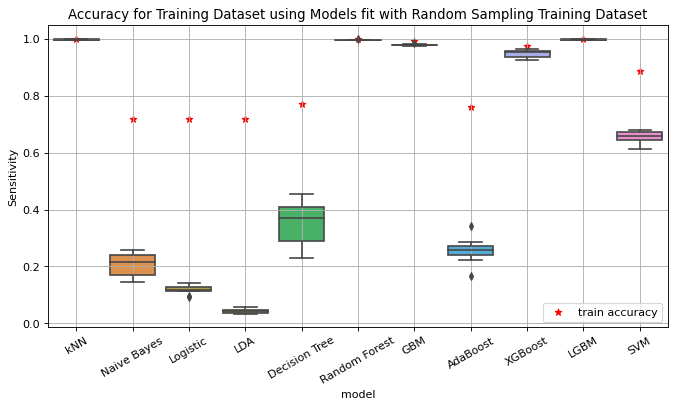

In [23]:
resample_train.rename(columns={"index":"model"},inplace = True)
plt.figure(figsize=(10,5), dpi=80)
sns.boxplot(x="model", y="Sensitivity", data=resample_train)
plt.scatter(train_df.index, train_df.Accuracy, color = 'r', marker = '*', label = "train accuracy")
plt.xticks(rotation=30)
plt.grid()
plt.legend(loc='lower right')
plt.title("Accuracy for Training Dataset using Models fit with Random Sampling Training Dataset") ## train dataset

Text(0.5, 1.0, 'Accuracy for Validation Dataset using Models fit with Random Sampling Training Dataset')

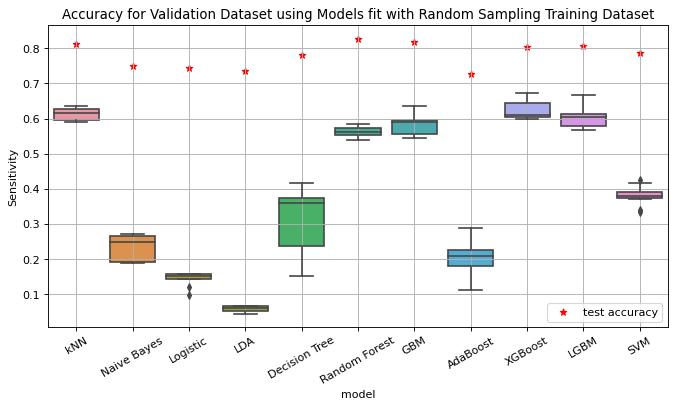

In [24]:
resample_test.rename(columns={"index":"model"},inplace = True)
plt.figure(figsize=(10,5), dpi=80)
sns.boxplot(x="model", y="Sensitivity", data=resample_test)
plt.scatter(test_df.index, test_df.Accuracy, color = 'r', marker = '*', label = "test accuracy")
plt.xticks(rotation=30)
plt.grid()
plt.legend(loc='lower right')
plt.title("Accuracy for Validation Dataset using Models fit with Random Sampling Training Dataset") ## test dataset

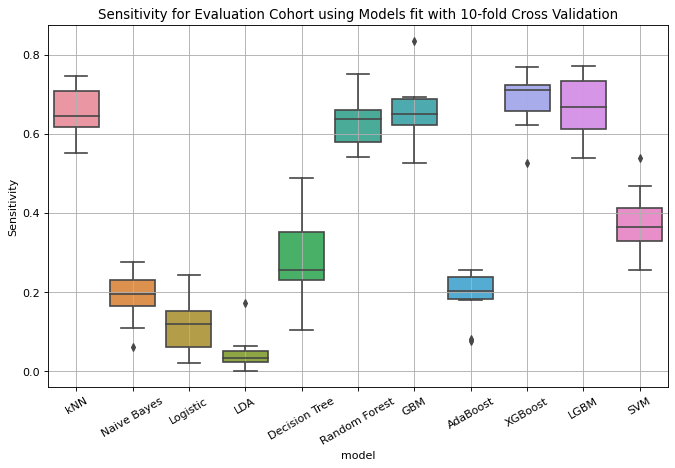

In [25]:
resample_val.rename(columns={"index":"model"},inplace = True)
plt.figure(figsize=(10,6), dpi=80)
sns.boxplot(x="model", y="Sensitivity", data=resample_val)
plt.xticks(rotation=30)
plt.grid()
plt.title("Sensitivity for Evaluation Cohort using Models fit with 10-fold Cross Validation") ## val dataset
plt.savefig("evaluation_sensitivity.png")

In [26]:
output_model_lst = model_name_lst
# output_model_lst = ['SVM']
print(output_model_lst)

['kNN', 'Naive Bayes', 'Logistic', 'LDA', 'Decision Tree', 'Random Forest', 'GBM', 'AdaBoost', 'XGBoost', 'LGBM', 'SVM']


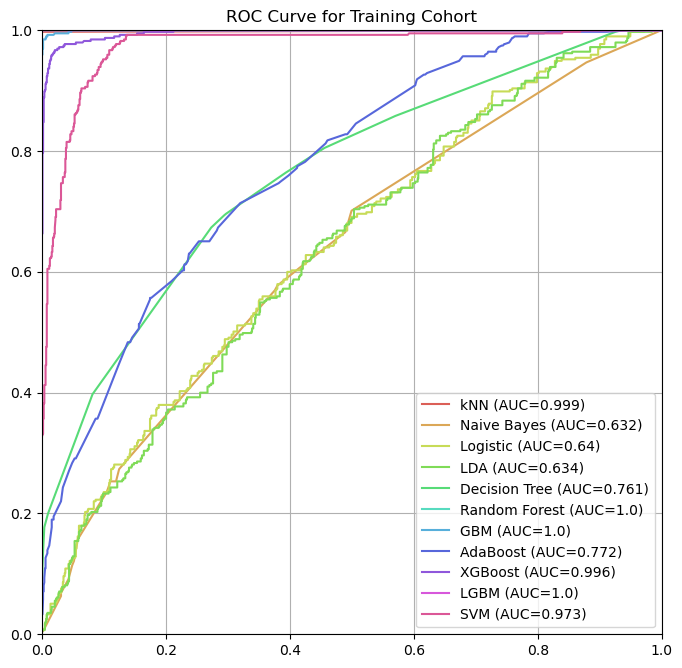

In [27]:
y_train = train_data[Y_name]

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(output_model_lst))
ax.set_prop_cycle('color', colors)
for model_name in output_model_lst:
    fpr, tpr, threshold = roc_curve(y_train, prob_train_df[model_name])
    auc = round(roc_auc_score(y_train, prob_train_df[model_name]),3)
    plt.plot(fpr, tpr, label = model_name+" (AUC="+str(auc)+")")
    
plt.legend(loc='lower right')
plt.title("ROC Curve for Training Cohort")
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig("train_roc.png")

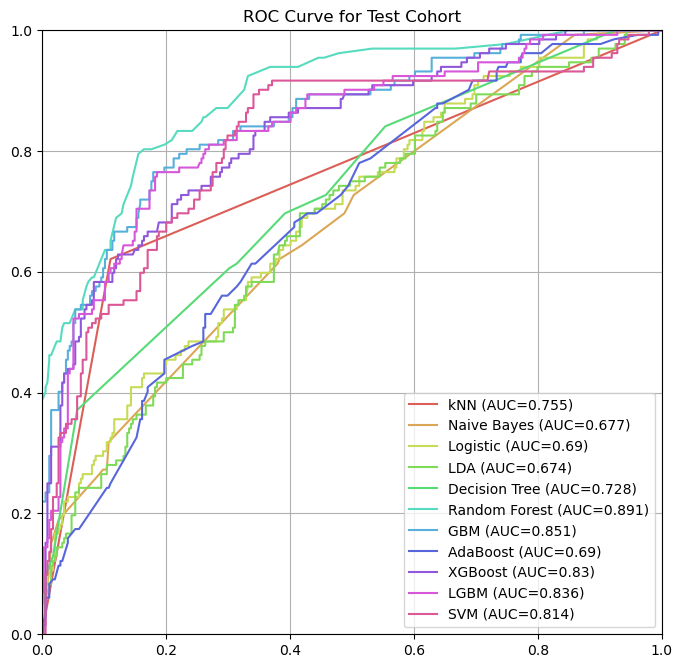

In [28]:
y_test = test_data[Y_name]

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(output_model_lst))
ax.set_prop_cycle('color', colors)
for model_name in output_model_lst:
    fpr, tpr, threshold = roc_curve(y_test, prob_test_df[model_name])
    auc = round(roc_auc_score(y_test, prob_test_df[model_name]),3)
    plt.plot(fpr, tpr, label = model_name+" (AUC="+str(auc)+")")
    
plt.legend(loc='lower right')
plt.title("ROC Curve for Test Cohort")
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig("test_roc.png")

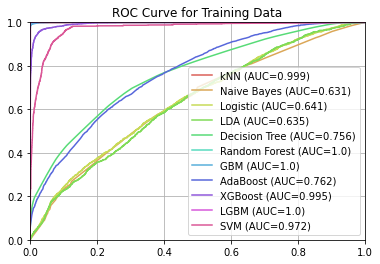

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(output_model_lst))
ax.set_prop_cycle('color', colors)
auc_ser = stat_train.AUC.apply(lambda t: t[0])
for model_name in output_model_lst:
    fpr, tpr, threshold = roc_curve(resample_y_train, prob_train[model_name])
#     auc = round(roc_auc_score(resample_y_train, prob_train[model_name]),3)
    auc = auc_ser[model_name]  ## same as stat_train
    plt.plot(fpr, tpr, label = model_name+" (AUC="+str(auc)+")")
    
plt.legend()
plt.title("ROC Curve for Training Data")
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig("fig_name.png")

(0.0, 1.0)

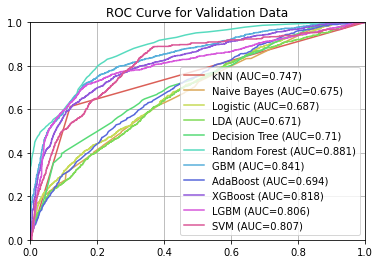

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(output_model_lst))
ax.set_prop_cycle('color', colors)
auc_ser = stat_test.AUC.apply(lambda t: t[0])
for model_name in output_model_lst:
    fpr, tpr, threshold = roc_curve(resample_y_test, prob_test[model_name])
#     auc = round(roc_auc_score(resample_y_test, prob_test[model_name]),3)
    auc = auc_ser[model_name]  ## same as stat_test
    plt.plot(fpr, tpr, label = model_name+" (AUC="+str(auc)+")")
plt.legend()
plt.title("ROC Curve for Validation Data") ## Test Dataset
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

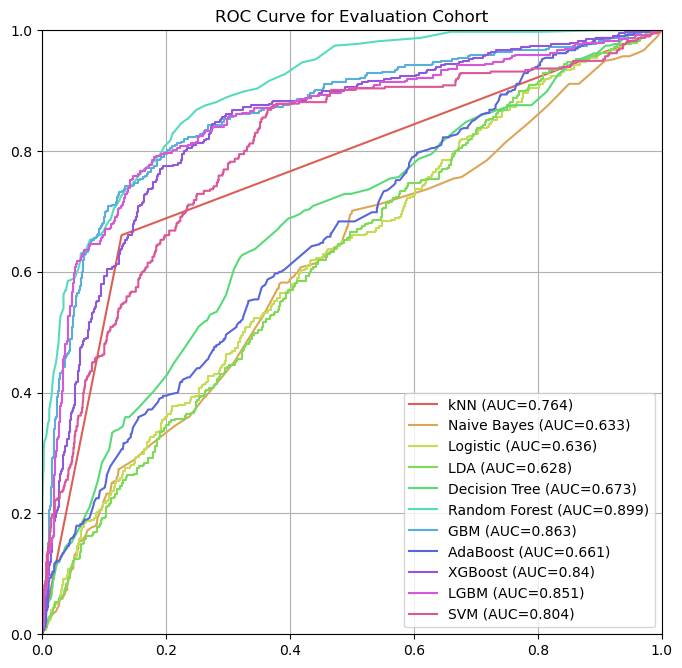

In [31]:
fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.add_subplot(111)
colors = sns.color_palette("hls", len(output_model_lst))
ax.set_prop_cycle('color', colors)
auc_ser = stat_val.AUC.apply(lambda t: t[0])
for model_name in output_model_lst:
    fpr, tpr, threshold = roc_curve(resample_y_val, prob_val[model_name])
#     auc = round(roc_auc_score(resample_y_val, prob_val[model_name]),3)
    auc = auc_ser[model_name]  ## same as stat_val
    plt.plot(fpr, tpr, label = model_name+" (AUC="+str(auc)+")")
plt.legend()
plt.title("ROC Curve for Evaluation Cohort") ## Val Dataset
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig("evaluation_roc.png")